In [1]:
# %pip install -U lightgbm==3.3.2

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

import pickle
from tqdm import tqdm
import gc
from pathlib import Path

In [2]:
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings("ignore")
sys.path.append("../src/") # path to the `src`` folder
InteractiveShell.ast_node_interactivity = "all"
tqdm.pandas()

In [3]:
from data import DataHelper
from data.metrics import map_at_k, hr_at_k, recall_at_k

from retrieval.rules import (
    OrderHistory,
    OrderHistoryDecay,
    ItemPair,
    UserGroupTimeHistory,
    UserGroupSaleTrend,
    TimeHistory,
    TimeHistoryDecay,
    SaleTrend,
    OutOfStock,
)
from retrieval.collector import RuleCollector

from features import cum_sale, week_sale, repurchase_ratio, purchased_before

from utils import (
    calc_valid_date,
    merge_week_data,
    reduce_mem_usage,
    calc_embd_similarity,
)


In [4]:
data_dir = Path("../data/")
model_dir = Path("../models/")

In [5]:
TRAIN_WEEK_NUM = 4
WEEK_NUM = TRAIN_WEEK_NUM + 2

VERSION_NAME = "pivot"
TEST = True # * Set as `False` when do local experiments to save time

In [6]:
import os
if not os.path.exists(data_dir/"interim"/VERSION_NAME):
    os.mkdir(data_dir/"interim"/VERSION_NAME)
if not os.path.exists(data_dir/"processed"/VERSION_NAME):
    os.mkdir(data_dir/"processed"/VERSION_NAME)

Pepare data: encoding ids and preprocessing

In [7]:
dh = DataHelper(data_dir)

In [8]:
# data = dh.preprocess_data(save=True, name="encoded_full") # * run only once, processed data will be saved

In [9]:
data = dh.load_data(name="encoded_full")

In [10]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

## Retrieval


Generate candidates for each week

In [ ]:
listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
data['user']['age_bins'] = pd.cut(data['user']['age'], listBin)

In [ ]:
# * WEEK_NUM = 0: test
# * WEEK_NUM = 1: valid
# * WEEK_NUM > 1: train
for week in range(1,WEEK_NUM):
    # * use sliding window to generate candidates
    if week == 0 and not TEST:
        continue
    trans = data["inter"]

    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")
    
    train, valid = dh.split_data(trans, start_date, end_date)
    train = train.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')

    last_week_start = pd.to_datetime(start_date) - pd.Timedelta(days=7)
    last_week_start = last_week_start.strftime("%Y-%m-%d")
    last_week = train.loc[train.t_dat >= last_week_start]
    
    last_3day_start = pd.to_datetime(start_date) - pd.Timedelta(days=3)
    last_3day_start = last_3day_start.strftime("%Y-%m-%d")
    last_3days = train.loc[train.t_dat >= last_3day_start]

    if week != 0:
        customer_list = valid["customer_id"].values
    else:
        customer_list = submission['customer_id'].values

    # * ========================== Retrieval Strategies ==========================

    candidates = RuleCollector().collect(
        valid = valid,
        customer_list=customer_list,
        rules=[
            OrderHistory(train, days=3, name='1'),
            OrderHistory(train, days=7, name='2'),
            OrderHistoryDecay(train, days=3, n=50, name='1'),
            OrderHistoryDecay(train, days=7, n=50, name='2'),
            ItemPair(OrderHistory(train, days=3).retrieve(), name='1'),
            ItemPair(OrderHistory(train, days=7).retrieve(), name='2'),
            ItemPair(OrderHistoryDecay(train, days=3, n=50).retrieve(), name='3'),
            ItemPair(OrderHistoryDecay(train, days=7, n=50).retrieve(), name='4'),
            UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50, name='1'),
            UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50, name='2'),
            UserGroupSaleTrend(data, customer_list, train, ['age_bins'], days=7, n=50),
            TimeHistory(customer_list, last_week, n=50, name='1'),
            TimeHistory(customer_list, last_3days, n=50, name='2'),
            TimeHistoryDecay(customer_list, train, days=3, n=50, name='1'),
            TimeHistoryDecay(customer_list, train, days=7, n=50, name='2'),
            SaleTrend(customer_list, train, days=7, n=50),
        ],
        filters=[OutOfStock(trans)],
        min_pos_rate=0.006,
        compress=False,
    )
    
    candidates = (
        pd.pivot_table(
            candidates,
            values="score",
            index=["customer_id", "article_id"],
            columns=["method"],
            aggfunc=np.sum,
        )
        .reset_index()
    )

    candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
    valid.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{week}_label.pqt")

Week 1: [2020-09-16, 2020-09-23)


Retrieve items by rules:   6%|▋         | 1/16 [00:26<06:33, 26.22s/it]

Positive rate: 0.03038


Retrieve items by rules:  12%|█▎        | 2/16 [00:53<06:11, 26.56s/it]

Positive rate: 0.02859


Retrieve items by rules:  19%|█▉        | 3/16 [02:05<10:18, 47.57s/it]

Positive rate: 0.01413


Retrieve items by rules:  25%|██▌       | 4/16 [03:21<11:45, 58.79s/it]

Positive rate: 0.01295
Positive rate: 0.01519


Retrieve items by rules:  31%|███▏      | 5/16 [03:45<08:27, 46.13s/it]

Positive rate: 0.01472


Retrieve items by rules:  38%|███▊      | 6/16 [04:11<06:34, 39.46s/it]

Positive rate: 0.00908


Retrieve items by rules:  44%|████▍     | 7/16 [04:54<06:03, 40.39s/it]

Positive rate: 0.00853


Retrieve items by rules:  50%|█████     | 8/16 [05:50<06:03, 45.49s/it]

TOP35.0 Positive rate: 0.00501


Retrieve items by rules:  56%|█████▋    | 9/16 [06:42<05:32, 47.53s/it]

TOP38.5 Positive rate: 0.00508


Retrieve items by rules:  62%|██████▎   | 10/16 [07:33<04:52, 48.71s/it]

TOP3.0 Positive rate: 0.00542


Retrieve items by rules:  69%|██████▉   | 11/16 [08:33<04:20, 52.01s/it]

TOP25.0 Positive rate: 0.00503


Retrieve items by rules:  75%|███████▌  | 12/16 [09:25<03:27, 51.93s/it]

TOP30.0 Positive rate: 0.00505


Retrieve items by rules:  81%|████████▏ | 13/16 [10:15<02:34, 51.55s/it]

TOP31.0 Positive rate: 0.00503


Retrieve items by rules:  88%|████████▊ | 14/16 [11:35<01:59, 59.95s/it]

TOP24.0 Positive rate: 0.00506


Retrieve items by rules:  94%|█████████▍| 15/16 [12:53<01:05, 65.58s/it]

TOP4.0 Positive rate: 0.00568


Retrieve items by rules: 100%|██████████| 16/16 [13:51<00:00, 51.95s/it]


Week 2: [2020-09-09, 2020-09-16)


Retrieve items by rules:   6%|▋         | 1/16 [00:25<06:24, 25.61s/it]

Positive rate: 0.03008


Retrieve items by rules:  12%|█▎        | 2/16 [00:52<06:08, 26.30s/it]

Positive rate: 0.02825


Retrieve items by rules:  19%|█▉        | 3/16 [02:06<10:26, 48.20s/it]

Positive rate: 0.01354


Retrieve items by rules:  25%|██▌       | 4/16 [03:24<12:00, 60.08s/it]

Positive rate: 0.01244
Positive rate: 0.01435


Retrieve items by rules:  31%|███▏      | 5/16 [03:49<08:41, 47.44s/it]

Positive rate: 0.01376


Retrieve items by rules:  38%|███▊      | 6/16 [04:18<06:49, 40.94s/it]

Positive rate: 0.00886


Retrieve items by rules:  44%|████▍     | 7/16 [05:04<06:23, 42.62s/it]

Positive rate: 0.00830


Retrieve items by rules:  50%|█████     | 8/16 [06:07<06:31, 49.00s/it]

TOP21.0 Positive rate: 0.00501


Retrieve items by rules:  56%|█████▋    | 9/16 [07:00<05:53, 50.53s/it]

TOP11.0 Positive rate: 0.00515


Retrieve items by rules:  69%|██████▉   | 11/16 [08:55<04:32, 54.45s/it]

skip
TOP13.0 Positive rate: 0.00502


Retrieve items by rules:  75%|███████▌  | 12/16 [09:48<03:35, 53.98s/it]

TOP6.0 Positive rate: 0.00544


Retrieve items by rules:  81%|████████▏ | 13/16 [10:43<02:42, 54.11s/it]

TOP11.0 Positive rate: 0.00500


Retrieve items by rules:  88%|████████▊ | 14/16 [12:06<02:05, 62.97s/it]

TOP11.0 Positive rate: 0.00517


Retrieve items by rules: 100%|██████████| 16/16 [14:29<00:00, 54.36s/it]

skip


Week 3: [2020-09-02, 2020-09-09)


Retrieve items by rules:   6%|▋         | 1/16 [00:25<06:19, 25.29s/it]

Positive rate: 0.02822


Retrieve items by rules:  12%|█▎        | 2/16 [00:51<05:59, 25.68s/it]

Positive rate: 0.02679


Retrieve items by rules:  19%|█▉        | 3/16 [02:03<10:08, 46.83s/it]

Positive rate: 0.01321


Retrieve items by rules:  25%|██▌       | 4/16 [03:19<11:39, 58.32s/it]

Positive rate: 0.01237
Positive rate: 0.01490


Retrieve items by rules:  31%|███▏      | 5/16 [03:43<08:25, 45.94s/it]

Positive rate: 0.01435


Retrieve items by rules:  38%|███▊      | 6/16 [04:09<06:34, 39.41s/it]

Positive rate: 0.00910


Retrieve items by rules:  44%|████▍     | 7/16 [05:03<06:35, 43.91s/it]

Positive rate: 0.00873


Retrieve items by rules:  50%|█████     | 8/16 [06:10<06:49, 51.25s/it]

TOP31.0 Positive rate: 0.00502


Retrieve items by rules:  56%|█████▋    | 9/16 [07:07<06:12, 53.21s/it]

TOP29.5 Positive rate: 0.00505


Retrieve items by rules:  69%|██████▉   | 11/16 [09:08<04:46, 57.39s/it]

skip
TOP20.0 Positive rate: 0.00501


Retrieve items by rules:  75%|███████▌  | 12/16 [10:04<03:47, 56.86s/it]

TOP17.0 Positive rate: 0.00519


Retrieve items by rules:  81%|████████▏ | 13/16 [11:00<02:49, 56.64s/it]

TOP17.0 Positive rate: 0.00515


Retrieve items by rules:  88%|████████▊ | 14/16 [12:24<02:10, 65.03s/it]

TOP18.0 Positive rate: 0.00522


Retrieve items by rules: 100%|██████████| 16/16 [14:48<00:00, 55.56s/it]

skip


Week 4: [2020-08-26, 2020-09-02)


Retrieve items by rules:   6%|▋         | 1/16 [00:25<06:19, 25.29s/it]

Positive rate: 0.02406


Retrieve items by rules:  12%|█▎        | 2/16 [00:51<06:01, 25.85s/it]

Positive rate: 0.02268


Retrieve items by rules:  19%|█▉        | 3/16 [02:05<10:19, 47.67s/it]

Positive rate: 0.01182


Retrieve items by rules:  25%|██▌       | 4/16 [03:20<11:43, 58.59s/it]

Positive rate: 0.01123
Positive rate: 0.01353


Retrieve items by rules:  31%|███▏      | 5/16 [03:44<08:27, 46.10s/it]

Positive rate: 0.01306


Retrieve items by rules:  38%|███▊      | 6/16 [04:11<06:36, 39.65s/it]

Positive rate: 0.00876


Retrieve items by rules:  44%|████▍     | 7/16 [05:08<06:48, 45.42s/it]

Positive rate: 0.00836


Retrieve items by rules:  50%|█████     | 8/16 [06:18<07:06, 53.25s/it]

TOP26.0 Positive rate: 0.00514


Retrieve items by rules:  56%|█████▋    | 9/16 [07:16<06:22, 54.67s/it]

TOP27.5 Positive rate: 0.00505


Retrieve items by rules:  69%|██████▉   | 11/16 [09:21<04:55, 59.17s/it]

skip
TOP26.0 Positive rate: 0.00503


Retrieve items by rules:  75%|███████▌  | 12/16 [10:17<03:52, 58.15s/it]

TOP26.0 Positive rate: 0.00508


Retrieve items by rules:  81%|████████▏ | 13/16 [11:14<02:53, 57.74s/it]

TOP19.0 Positive rate: 0.00500


Retrieve items by rules:  88%|████████▊ | 14/16 [12:39<02:12, 66.04s/it]

TOP14.0 Positive rate: 0.00502


Retrieve items by rules: 100%|██████████| 16/16 [15:05<00:00, 56.56s/it]

skip


Week 5: [2020-08-19, 2020-08-26)


Retrieve items by rules:   6%|▋         | 1/16 [00:25<06:18, 25.22s/it]

Positive rate: 0.02329


Retrieve items by rules:  12%|█▎        | 2/16 [00:51<06:04, 26.03s/it]

Positive rate: 0.02211


Retrieve items by rules:  19%|█▉        | 3/16 [02:00<09:53, 45.62s/it]

Positive rate: 0.01187


Retrieve items by rules:  25%|██▌       | 4/16 [03:12<11:11, 55.99s/it]

Positive rate: 0.01101
Positive rate: 0.01325


Retrieve items by rules:  31%|███▏      | 5/16 [03:36<08:07, 44.36s/it]

Positive rate: 0.01269


Retrieve items by rules:  38%|███▊      | 6/16 [04:02<06:21, 38.16s/it]

Positive rate: 0.00869


Retrieve items by rules:  44%|████▍     | 7/16 [04:55<06:28, 43.13s/it]

Positive rate: 0.00826


Retrieve items by rules:  50%|█████     | 8/16 [06:03<06:46, 50.82s/it]

TOP15.5 Positive rate: 0.00506


Retrieve items by rules:  56%|█████▋    | 9/16 [06:39<05:23, 46.19s/it]

TOP22.0 Positive rate: 0.00502


Retrieve items by rules:  69%|██████▉   | 11/16 [08:19<04:03, 48.70s/it]

skip
TOP6.0 Positive rate: 0.00517


Retrieve items by rules:  75%|███████▌  | 12/16 [08:57<03:02, 45.65s/it]

TOP11.0 Positive rate: 0.00502


Retrieve items by rules:  81%|████████▏ | 13/16 [09:46<02:19, 46.63s/it]

TOP6.0 Positive rate: 0.00513


Retrieve items by rules:  88%|████████▊ | 14/16 [10:58<01:48, 54.24s/it]

TOP10.0 Positive rate: 0.00505


Retrieve items by rules: 100%|██████████| 16/16 [12:58<00:00, 48.68s/it]

skip


In [ ]:
# * use the threshold in week 1 to generate candidates for test data, see the log in the upper cell 
if TEST:
    week = 0
    trans = data["inter"]
    
    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")
    
    train, valid = dh.split_data(trans, start_date, end_date)
    train = train.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')

    last_week_start = pd.to_datetime(start_date) - pd.Timedelta(days=7)
    last_week_start = last_week_start.strftime("%Y-%m-%d")
    last_week = train.loc[train.t_dat >= last_week_start]
    
    last_3day_start = pd.to_datetime(start_date) - pd.Timedelta(days=3)
    last_3day_start = last_3day_start.strftime("%Y-%m-%d")
    last_3days = train.loc[train.t_dat >= last_3day_start]

    customer_list = submission['customer_id'].values

    # * ========================== Retrieval Strategies ==========================

    candidates = RuleCollector().collect(
        valid = valid,
        customer_list=customer_list,
        rules=[
            OrderHistory(train, days=3, name='1'),
            OrderHistory(train, days=7, name='2'),
            OrderHistoryDecay(train, days=3, n=50, name='1'),
            OrderHistoryDecay(train, days=7, n=50, name='2'),
            ItemPair(OrderHistory(train, days=3).retrieve(), name='1'),
            ItemPair(OrderHistory(train, days=7).retrieve(), name='2'),
            ItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),
            ItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),
            UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=35, name='1'),
            UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=38.5, name='2'),
            UserGroupSaleTrend(data, customer_list, train, ['age_bins'], days=7, n=3),
            TimeHistory(customer_list, last_week, n=25, name='1'),
            TimeHistory(customer_list, last_3days, n=30, name='2'),
            TimeHistoryDecay(customer_list, train, days=3, n=31, name='1'),
            TimeHistoryDecay(customer_list, train, days=7, n=24, name='2'),
            SaleTrend(customer_list, train, days=7, n=4),
        ],
        filters=[OutOfStock(trans)],
        min_pos_rate=0.006,
        compress=False,
    )
    
    candidates, _ = reduce_mem_usage(candidates)
    candidates = (
        pd.pivot_table(
            candidates,
            values="score",
            index=["customer_id", "article_id"],
            columns=["method"],
            aggfunc=np.sum,
        )
        .reset_index()
    )

    candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
    valid.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{week}_label.pqt")

In [37]:
del train, valid, last_week, customer_list, candidates
gc.collect()

106

## Feature engineering


In [38]:
user = data["user"]
item = data["item"]
inter = data["inter"]

In [39]:
# merge `product_code`
inter = inter.merge(item[["article_id", "product_code"]], on="article_id", how="left")
# calculate week number
inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7

In [40]:
inter = inter.sort_values(["customer_id", "t_dat"]).reset_index(drop=True)

In [41]:
inter.shape

(31788324, 7)

Week Sale

In [42]:
inter["item_sale"] = week_sale(inter, ["article_id"])
inter["pro_sale"] = week_sale(inter, ["product_code"])
inter["item_sale_uni"] = week_sale(inter, ["article_id"], True)
inter["pro_sale_uni"] = week_sale(inter, ["product_code"], True)

inter["item_sale_ratio"] = inter["item_sale"] / (inter["pro_sale"] + 1e-6)
inter["item_sale_uni_ratio"] = inter["pro_sale_uni"] / (inter["pro_sale_uni"] + 1e-6)

item_feats = [
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",
]
inter = inter.merge(item[["article_id", *item_feats]], on="article_id", how="left")

for feat in tqdm(item_feats):
    inter[f"{feat}_sale"] = week_sale(inter, [feat], f"{feat}_sale")

inter = inter.drop(columns=item_feats)

100%|██████████| 6/6 [01:03<00:00, 10.57s/it]


Repurchase Ratio

In [43]:
inter['i_repurchase_ratio'] = repurchase_ratio(inter, ['article_id'])
inter['p_repurchase_ratio'] = repurchase_ratio(inter, ['product_code'])

Already Bought Item

In [44]:
inter["purchased_item"] = purchased_before(inter, ["article_id"])
inter["purchased_pro"] = purchased_before(inter, ["product_code"])

Save data

In [45]:
inter.shape

(31788324, 23)

In [46]:
inter.to_parquet(data_dir / "processed/processed_inter.pqt")

## Merge Features


In [11]:
inter = pd.read_parquet(data_dir / "processed/processed_inter.pqt")
data["inter"] = inter

In [12]:
#* embeddings from DSSM model
dssm_user_embd = np.load(data_dir / "external/dssm_user_embd.npy", allow_pickle=True)
dssm_item_embd = np.load(data_dir / "external/dssm_item_embd.npy", allow_pickle=True)
# * embeddings from YouTubeDNN model
yt_user_embd = np.load(data_dir / "external/yt_user_embd.npy", allow_pickle=True)
yt_item_embd = np.load(data_dir / "external/yt_item_embd.npy", allow_pickle=True)

In [ ]:
def calc_embd_similarity(candidate, user_embd, item_embd) -> np.ndarray:
    # * maybe add embedding statistic info like std, mean, etc? 
    sim = np.zeros(candidate.shape[0])
    batch_size = 10000
    for batch in tqdm(range(0, candidate.shape[0], batch_size)):
        tmp_users = candidate.loc[batch : batch + batch_size - 1, 'customer_id'].values-1
        tmp_items = candidate.loc[batch : batch + batch_size - 1, 'article_id'].values-1
        tmp_user_embd = np.expand_dims(user_embd[tmp_users],1) # (batch_size, 1, dim)
        tmp_item_embd = np.expand_dims(item_embd[tmp_items],2) # (batch_size, dim, 1)
        tmp_sim = np.einsum('ijk,ikj->ij', tmp_user_embd, tmp_item_embd)
        sim[batch : batch + batch_size] = tmp_sim.reshape(-1)
    return sim

In [14]:
for i in tqdm(range(WEEK_NUM)):
    if i == 0 and not TEST:
        continue
        
    candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate.pqt")
    # * merge features
    candidate = merge_week_data(data, i, candidate)
    # * merge DSSM user and item embeddings
    candidate["dssm_similarity"] = calc_embd_similarity(candidate, dssm_user_embd, dssm_item_embd)
    # * merge YouTubeDNN user and item embeddings
    candidate["yt_similarity"] = calc_embd_similarity(candidate, yt_user_embd, yt_item_embd)

    candidate.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")

100%|██████████| 6/6 [16:00<00:00, 160.16s/it]


In [15]:
del dssm_user_embd, dssm_item_embd, yt_user_embd, yt_item_embd
gc.collect()

29

## Ranking


In [11]:
candidates = {}
labels = {}
for i in tqdm(range(1, WEEK_NUM)):
    candidates[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")
    labels[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_label.pqt")

100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


In [12]:
feats = [
    x
    for x in candidates[1].columns
    if x
    not in [
        "label",
        "sales_channel_id",
        "t_dat",
        "week",
        "WeekSaleTrend_item",
        "WeekSaleTrend_pro",
        "ThreeDaySaleTrend_item",
        "ThreeDaySaleTrend_pro",
    ]
]
cat_features = [
    "customer_id",
    "article_id",
    "product_code",
    "FN",
    "Active",
    "club_member_status",
    "fashion_news_frequency",
    "age",
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",
]


In [13]:
# * Convert categorical featues as `CategoricalDtype`
cate_dict = {}        
for feat in tqdm(cat_features):
    if feat in data['user'].columns:
        value_set = set(data['user'][feat].unique())
    elif feat in data['item'].columns:
        value_set = set(data['item'][feat].unique())
    else:
        value_set = set(data['inter'][feat].unique())
    cate_dict[feat] = CategoricalDtype(categories=value_set)

100%|██████████| 14/14 [00:00<00:00, 19.61it/s]


In [14]:
for i in tqdm(range(1,WEEK_NUM)):
    for feat in cat_features:
        candidates[i][feat] = candidates[i][feat].astype(cate_dict[feat])

100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


In [15]:
# # * Convert categorical featues as `CategoricalDtype`
# cate_dict = {f:set() for f in cat_features}
# for i in tqdm(range(WEEK_NUM)):
#     if i==0 and not TEST:
#         continue
#     elif i==0:
#         tmp_candidate = pd.read_parquet(data_dir/"processed"/VERSION_NAME/"week0_candidate.pqt")
#     else:
#         tmp_candidate = candidates[i]
        
#     for feat in cat_features:
#         cate_dict[feat] = cate_dict[feat] | set(tmp_candidate[feat].unique())
        
# for feat in tqdm(cat_features):
#     cate_dict[feat] = CategoricalDtype(categories=cate_dict[feat])

# for i in tqdm(range(1,WEEK_NUM)):
#     for feat in cat_features:
#         candidates[i][feat] = candidates[i][feat].astype(cate_dict[feat])

### Train


In [23]:
params = {
    "objective": "lambdarank",
    "boosting_type": "gbdt",
    "metric": "map",
    "max_depth": 8,
    "num_leaves": 128,
    "learning_rate": 0.01,

    "verbose": -1,
    "eval_at": 12,
    # 'device':'gpu'
}

In [17]:
# * some rules are skipped for some weeks, we need to concat them together
# * to merge the columns
full_data = pd.concat(candidates[i] for i in range(1, WEEK_NUM))

In [18]:
train = full_data[full_data["week"] != 1]
valid = full_data[full_data["week"] == 1]
del full_data

In [19]:
train = train.sort_values(by=['week', 'customer_id'],ascending=True).reset_index(drop=True)

In [20]:
sum(train['label']==0) / len(train)
# 0.9946384702188372 4-week
# 0.994541076811467 4-week remove all-negative customer
# 0.9937656578410653 4-week min_pos_rate = 0.005

0.9937656578410653

In [21]:
valid = valid.sort_values(by=['customer_id'],ascending=True).reset_index(drop=True)

In [22]:
train_group = train[["customer_id", "article_id", "week"]]
train_group = train_group.astype("int") # * convert to int to avoid `0` in groupby count result
train_group = train_group.groupby(["week","customer_id"])['article_id'].count().values

valid_group = valid[["customer_id", "article_id"]]
valid_group = valid_group.astype("int") # * convert to int to avoid `0` in groupby count result
valid_group = valid_group.groupby(["customer_id"])['article_id'].count().values

In [24]:
train_set = lgb.Dataset(
    data=train[feats],
    label=train["label"],
    group=train_group,
    feature_name=feats,
    categorical_feature=cat_features,
    params=params,
)

valid_set = lgb.Dataset(
    data=valid[feats],
    label=valid["label"],
    group=valid_group,
    feature_name=feats,
    categorical_feature=cat_features,
    params=params,
)

ranker = lgb.train(
    params,
    train_set,
    num_boost_round=300,
    valid_sets=[valid_set],
    early_stopping_rounds=30,
    verbose_eval=10
)
# 0.82846 4-week
# 0.828932 3-week
# 0.766476 4-week min_pos_rate 0.005 lr=0.03
# 0.766921 4-week min_pos_rate 0.005 lr=0.01

Training until validation scores don't improve for 30 rounds
[10]	valid_0's map@12: 0.766043
[20]	valid_0's map@12: 0.766281
[30]	valid_0's map@12: 0.766571
[40]	valid_0's map@12: 0.766322
[50]	valid_0's map@12: 0.766553
[60]	valid_0's map@12: 0.766634
[70]	valid_0's map@12: 0.766772
[80]	valid_0's map@12: 0.76674
[90]	valid_0's map@12: 0.766778
[100]	valid_0's map@12: 0.766632
[110]	valid_0's map@12: 0.766665
Early stopping, best iteration is:
[88]	valid_0's map@12: 0.766846


In [69]:
ranker.save_model(model_dir / "lgb_ranker.model", num_iteration=ranker.best_iteration)

### Inference

In [14]:
ranker = lgb.Booster(model_file=model_dir / "lgb_ranker.model")

<Figure size 576x864 with 0 Axes>

<AxesSubplot:xlabel='importance', ylabel='feature'>

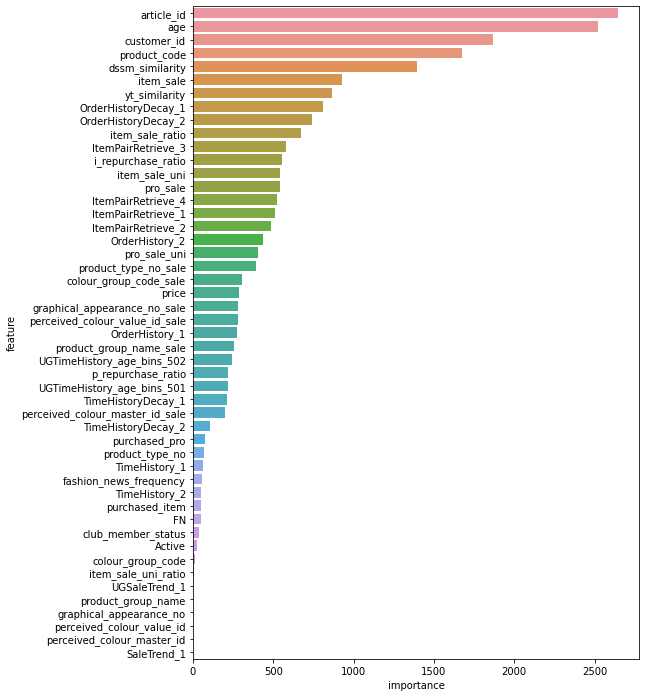

In [25]:
feat_importance = pd.DataFrame(
    {"feature": feats, "importance": ranker.feature_importance()}
).sort_values(by="importance", ascending=False)
plt.figure(figsize=(8, 12))
sns.barplot(y="feature", x="importance", data=feat_importance)

### Validate

In [26]:
val_candidates = valid.reset_index(drop=True)

In [27]:
probs = np.zeros(val_candidates.shape[0])
batch_size = 5_000_000
for batch in tqdm(range(0, val_candidates.shape[0], batch_size)):
    outputs = ranker.predict(val_candidates.loc[batch : batch + batch_size - 1, feats])
    probs[batch : batch + batch_size] = outputs

100%|██████████| 2/2 [00:12<00:00,  6.18s/it]


In [28]:
val_candidates["prob"] = probs

In [29]:
pred_lgb = val_candidates[['customer_id','article_id','prob']]
pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)

In [30]:
pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')

In [31]:
pred_lgb = pred_lgb.groupby("customer_id")["prediction"].progress_apply(list).reset_index()

100%|██████████| 1371980/1371980 [01:29<00:00, 15365.01it/s]


In [32]:
label = labels[1]
label = pd.merge(label, pred_lgb, on="customer_id", how="left")

In [33]:
map_at_k(label["article_id"], label["prediction"], k=12)

# 0.02820525160663368 1-week add normalization
# 0.028936597823123886 4-week 0.0274
# 0.029111989281461418 4-week drop full-negative customer
# 0.029165419468984943 3-week 0.0270
# 0.028694388096248934 4-week min_pos_rate 0.005 lr=0.03
# 0.028927037894290773 4-week min_pos_rate 0.005 lr=0.01
# 0.028936597823123886 4-week min_pos_rate 0.005 lr=0.01 max_depth=9, num_leaves=256

0.02880970090040666

### Test

In [71]:
del candidates, train, valid, train_group, valid_group, train_set, valid_set
gc.collect()

In [16]:
test_candidates = pd.read_parquet(data_dir/"processed"/VERSION_NAME/"week0_candidate.pqt")
for feat in cat_features:
    test_candidates[feat] = test_candidates[feat].astype(cate_dict[feat])

In [20]:
probs = np.zeros(test_candidates.shape[0])
batch_size = 5_000_000
for batch in tqdm(range(0, test_candidates.shape[0], batch_size)):
    outputs = ranker.predict(test_candidates.loc[batch : batch + batch_size - 1, feats])
    probs[batch : batch + batch_size] = outputs

100%|██████████| 20/20 [01:21<00:00,  4.08s/it]


In [21]:
test_candidates["prob"] = probs

In [22]:
pred_lgb = test_candidates[['customer_id','article_id','prob']]
pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)

In [23]:
idx2uid = pickle.load(open(data_dir/"index_id_map/user_index2id.pkl", "rb"))
idx2iid = pickle.load(open(data_dir/"index_id_map/item_index2id.pkl", "rb"))

In [24]:
pred_lgb['prediction'] = pred_lgb['prediction'].map(idx2iid).progress_apply(lambda x:'0'+str(x))
pred_lgb = pred_lgb.groupby('customer_id')['prediction'].progress_apply(list).reset_index()
pred_lgb['prediction'] = pred_lgb['prediction'].progress_apply(lambda x: ' '.join(x[:12]))

100%|██████████| 1371980/1371980 [00:01<00:00, 919265.99it/s]


In [25]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

In [26]:
del submission['prediction']
submission = submission.merge(pred_lgb, on='customer_id', how='left')
submission['customer_id'] = submission['customer_id'].map(idx2uid)

In [27]:
submission.to_csv('submission.csv', index=False)

In [28]:
submission.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0918522001 0751471043 0779781015 05...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0918522001 0918292001 0158340001 0863583001 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0805000001 0918522001 0918292001 06...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0918522001 0751471043 0863595006 0751471001 09...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0896152001 0927530006 0852584001 0791587001 08...


### Submit

In [46]:
submit_msg = """
0.028927037894290773 4-week drop
---
OrderHistory(train, days=3, name='1'),
OrderHistory(train, days=7, name='2'),
OrderHistoryDecay(train, days=3, n=50, name='1'),
OrderHistoryDecay(train, days=7, n=50, name='2'),
ItemPair(OrderHistory(train, days=3).retrieve(), name='1'),
ItemPair(OrderHistory(train, days=7).retrieve(), name='2'),
ItemPair(OrderHistoryDecay(train, days=3, n=50).retrieve(), name='3'),
ItemPair(OrderHistoryDecay(train, days=7, n=50).retrieve(), name='4'),
UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50, name='1'),
UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50, name='2'),
UserGroupSaleTrend(data, customer_list, train, ['age_bins'], days=7, n=50),
TimeHistory(customer_list, last_week, n=50, name='1'),
TimeHistory(customer_list, last_3days, n=50, name='2'),
TimeHistoryDecay(customer_list, train, days=3, n=50, name='1'),
TimeHistoryDecay(customer_list, train, days=7, n=50, name='2'),
SaleTrend(customer_list, train, days=7, n=50)
---
min_pos_rate = 0.005
pivot
"""

In [47]:
submit_msg

"\n0.029111989281461418 4-week drop full negative user\n---\nOrderHistory(train, 3),\nOrderHistory(train, 7),\nOrderHistoryDecay(train, 3, n=50),\nOrderHistoryDecay(train, 7, n=50),\nItemPair(OrderHistory(train, 3).retrieve(), name='1'),\nItemPair(OrderHistory(train, 7).retrieve(), name='2'),\nItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),\nItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),\nUserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50 if week!=0 else 15, name='1'),\nUserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50 if week!=0 else 20.5, name='2'),\nUserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50 if week!=0 else 2),\nTimeHistory(customer_list, last_week, n=50 if week!=0 else 9, name='1'),\nTimeHistory(customer_list, last_3days, n=50 if week!=0 else 16, name='2'),\nTimeHistoryDecay(customer_list, train, 3, n=50 if week!=0 else 12),\nTimeHistoryDecay(customer_list, train, 7, n=50 if w

In [60]:
# ! mkdir ~/.kaggle
# ! cp ../kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [65]:
# %pip install kaggle

     |████████████████████████████████| 58 kB 3.9 MB/s eta 0:00:011
     |████████████████████████████████| 78 kB 5.7 MB/s eta 0:00:011
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=2aaa2ba8e16413cb4c49862167277c1d8f29337d273f3f9b02c7f2a0d2b3a357
  Stored in directory: /root/.cache/pip/wheels/29/da/11/144cc25aebdaeb4931b231e25fd34b394e6a5725cbb2f50106
Successfully built kaggle
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [48]:
! kaggle competitions submit -c h-and-m-personalized-fashion-recommendations -f ./submission.csv -m '\n0.029111989281461418 4-week drop full negative user\n---\nOrderHistory(train, 3),\nOrderHistory(train, 7),\nOrderHistoryDecay(train, 3, n=50),\nOrderHistoryDecay(train, 7, n=50),\nItemPair(OrderHistory(train, 3).retrieve(), name='1'),\nItemPair(OrderHistory(train, 7).retrieve(), name='2'),\nItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),\nItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),\nUserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50 if week!=0 else 15, name='1'),\nUserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50 if week!=0 else 20.5, name='2'),\nUserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50 if week!=0 else 2),\nTimeHistory(customer_list, last_week, n=50 if week!=0 else 9, name='1'),\nTimeHistory(customer_list, last_3days, n=50 if week!=0 else 16, name='2'),\nTimeHistoryDecay(customer_list, train, 3, n=50 if week!=0 else 12),\nTimeHistoryDecay(customer_list, train, 7, n=50 if week!=0 else 8),\nSaleTrend(customer_list, train, 7, n=50 if week!=0 else 2)\n---\nmin_pos_rate = 0.006\npivot\n'

100%|████████████████████████████████████████| 258M/258M [00:11<00:00, 22.7MB/s]
Successfully submitted to H&M Personalized Fashion Recommendations